# МО для маркетплейса «В один клик»

Проект посвящён разработке модели машинного обучения, которая поможет маркетплейсу «В один клик» предсказывать вероятность снижения покупательской активности клиента в следующие три месяца. В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца. Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

In [6]:
# устанавливаю библиотеку shap
!pip install shap 
!pip install phik

In [7]:
# загружаю все нужные для проекта библиотеки

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phik
import seaborn as sns

from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

import shap


In [8]:
def load_data(file_name):
    """
    Load data from a CSV file and display its head and info.

    This function reads a CSV file, with data separated by semicolons and decimals
    denoted by commas, into a pandas DataFrame. It also displays the first few rows of the
    DataFrame (the head) and summarizes the columns.

    Parameters
    ----------
    file_name : str
        The name (and path, if necessary) of the CSV file from which to load data.

    Returns
    -------
    data : pandas.DataFrame
        The data loaded from the CSV file.
    """
    data = pd.read_csv(file_name, sep=';', decimal=',')  # разделила данные в датасете по столбцам и поправила разделитель в дробях
    print(data.head())
    data.info()
    return data

def load_data_2(file_name):
    """
    Load data from a CSV file and display its head and info.

    This function reads a CSV file, with data separated by semicolons and decimals
    denoted by commas, into a pandas DataFrame. It also displays the first few rows of the
    DataFrame (the head) and summarizes the columns.

    Parameters
    ----------
    file_name : str
        The name (and path, if necessary) of the CSV file from which to load data.

    Returns
    -------
    data : pandas.DataFrame
        The data loaded from the CSV file.
    """
    data = pd.read_csv(file_name, sep=',', decimal=',')  # разделила данные в датасете по столбцам и поправила разделитель в дробях
    columns_to_fix = {'Маркет_актив_6_мес': 'float32', 'Акционные_покупки': 'float32', 'Выручка': 'float32'}
    for column, dtype in columns_to_fix.items():
        if column in data.columns:
            data[column] = data[column].astype(dtype)
    print(data.head())
    data.info()
    return data

def clean_columns(data):
    """
    Cleans the column names of a pandas DataFrame.

    :param data: The pandas DataFrame to clean the column names of.
    :type data: pandas.DataFrame
    :return: The pandas DataFrame with cleaned column names.
    :rtype: pandas.DataFrame
    """
    data.columns = data.columns.str.lower().str.replace(' ', '_')
    print(data.head())
    return data

Написала две функции для выгрузки значений, потому что load_data с разделителем ';' ломает структуру в таблицах market_money и market_time, хотя там изначально не было проблем с выводом таблицы.

## Загрузка и изучение данных

In [9]:
try:
    client_info = load_data_2('/Users/ira-bobrineva/Downloads/market_file.csv')
except:
    client_info = load_data_2('/datasets/market_file.csv')

       id Покупательская активность Тип сервиса Разрешить сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась   стандартт                нет   
3  215351                 Снизилась   стандартт                 да   
4  215352                 Снизилась   стандартт                нет   

   Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   

  Популярная_категория  Средний_просмотр_категорий_за_визит  \
0     Товары для детей             

In [10]:
try:
    client_revenue_per_month = load_data_2('/Users/ira-bobrineva/Downloads/market_money.csv')
except:
    client_revenue_per_month = load_data_2('/datasets/market_money.csv')

       id               Период      Выручка
0  215348  препредыдущий_месяц     0.000000
1  215348        текущий_месяц  3293.100098
2  215348     предыдущий_месяц     0.000000
3  215349  препредыдущий_месяц  4472.000000
4  215349        текущий_месяц  4971.600098
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float32
dtypes: float32(1), int64(1), object(1)
memory usage: 76.3+ KB


In [11]:
try:
    client_time = load_data_2('/Users/ira-bobrineva/Downloads/market_time.csv')
except:
    client_time = load_data_2('/datasets/market_time.csv')

       id            Период  минут
0  215348     текущий_месяц     14
1  215348  предыдцщий_месяц     13
2  215349     текущий_месяц     10
3  215349  предыдцщий_месяц     12
4  215350     текущий_месяц     13
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [12]:
try:
    revenue_sum = load_data('/Users/ira-bobrineva/Downloads/money.csv')
except:
    revenue_sum = load_data('/datasets/money.csv')

       id  Прибыль
0  215348     0.98
1  215349     4.16
2  215350     3.13
3  215351     4.87
4  215352     4.21
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


В таблицах client_info и client_revenue_per_month надо поправить типы данных в некоторых столбцах. Надо привести названия столбцов к одному виду + проверить значения в столбцах с object-значениями. Например, в 'типе сервиса' есть ошибка в написании типа 'стандарт'. Пропусков в значениях нет.

## Предобработка 

### Обработка названий переменных

In [13]:
client_info = clean_columns(client_info)


       id покупательская_активность тип_сервиса разрешить_сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась   стандартт                нет   
3  215351                 Снизилась   стандартт                 да   
4  215352                 Снизилась   стандартт                нет   

   маркет_актив_6_мес  маркет_актив_тек_мес  длительность  акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   

  популярная_категория  средний_просмотр_категорий_за_визит  \
0     Товары для детей             

In [14]:
client_revenue_per_month = clean_columns(client_revenue_per_month)

       id               период      выручка
0  215348  препредыдущий_месяц     0.000000
1  215348        текущий_месяц  3293.100098
2  215348     предыдущий_месяц     0.000000
3  215349  препредыдущий_месяц  4472.000000
4  215349        текущий_месяц  4971.600098


In [15]:
client_time = clean_columns(client_time)

       id            период  минут
0  215348     текущий_месяц     14
1  215348  предыдцщий_месяц     13
2  215349     текущий_месяц     10
3  215349  предыдцщий_месяц     12
4  215350     текущий_месяц     13


In [16]:
revenue_sum = clean_columns(revenue_sum)

       id  прибыль
0  215348     0.98
1  215349     4.16
2  215350     3.13
3  215351     4.87
4  215352     4.21


### Обработка неявных дубликатов

In [17]:
client_info['тип_сервиса'].value_counts()

тип_сервиса
стандарт     914
премиум      376
стандартт     10
Name: count, dtype: int64

Поправлю значение 'стандартт', уберу тем самым неявный дубликат.

In [18]:
client_info['тип_сервиса'] = client_info['тип_сервиса'].replace('стандартт', 'стандарт')
client_info['тип_сервиса'].value_counts()

тип_сервиса
стандарт    924
премиум     376
Name: count, dtype: int64

In [19]:
client_info['популярная_категория'].value_counts()

популярная_категория
Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: count, dtype: int64

In [20]:
client_info['популярная_категория'] = client_info['популярная_категория'].str.replace('аксесуары', 'аксессуары') # убираю ошибку в названии категории
client_info['популярная_категория'].value_counts()

популярная_категория
Товары для детей                        330
Домашний текстиль                       251
Косметика и аксессуары                  223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: count, dtype: int64

In [21]:
client_revenue_per_month['период'].value_counts()

период
препредыдущий_месяц    1300
текущий_месяц          1300
предыдущий_месяц       1300
Name: count, dtype: int64

In [22]:
client_revenue_per_month['период'] = client_revenue_per_month['период'].str.replace('препредыдущий', 'предпредыдущий') # убираю ошибку в названии периода
client_revenue_per_month['период'].value_counts()

период
предпредыдущий_месяц    1300
текущий_месяц           1300
предыдущий_месяц        1300
Name: count, dtype: int64

In [23]:
client_time['период'].value_counts()

период
текущий_месяц       1300
предыдцщий_месяц    1300
Name: count, dtype: int64

In [24]:
client_time['период'] = client_time['период'].str.replace('предыдцщий', 'предыдущий') # убираю ошибку в названии периода
client_time['период'].value_counts()

период
текущий_месяц       1300
предыдущий_месяц    1300
Name: count, dtype: int64

Полных дубликатов в данных нет.

## Исследовательский анализ

### Распределение категориальных признаков

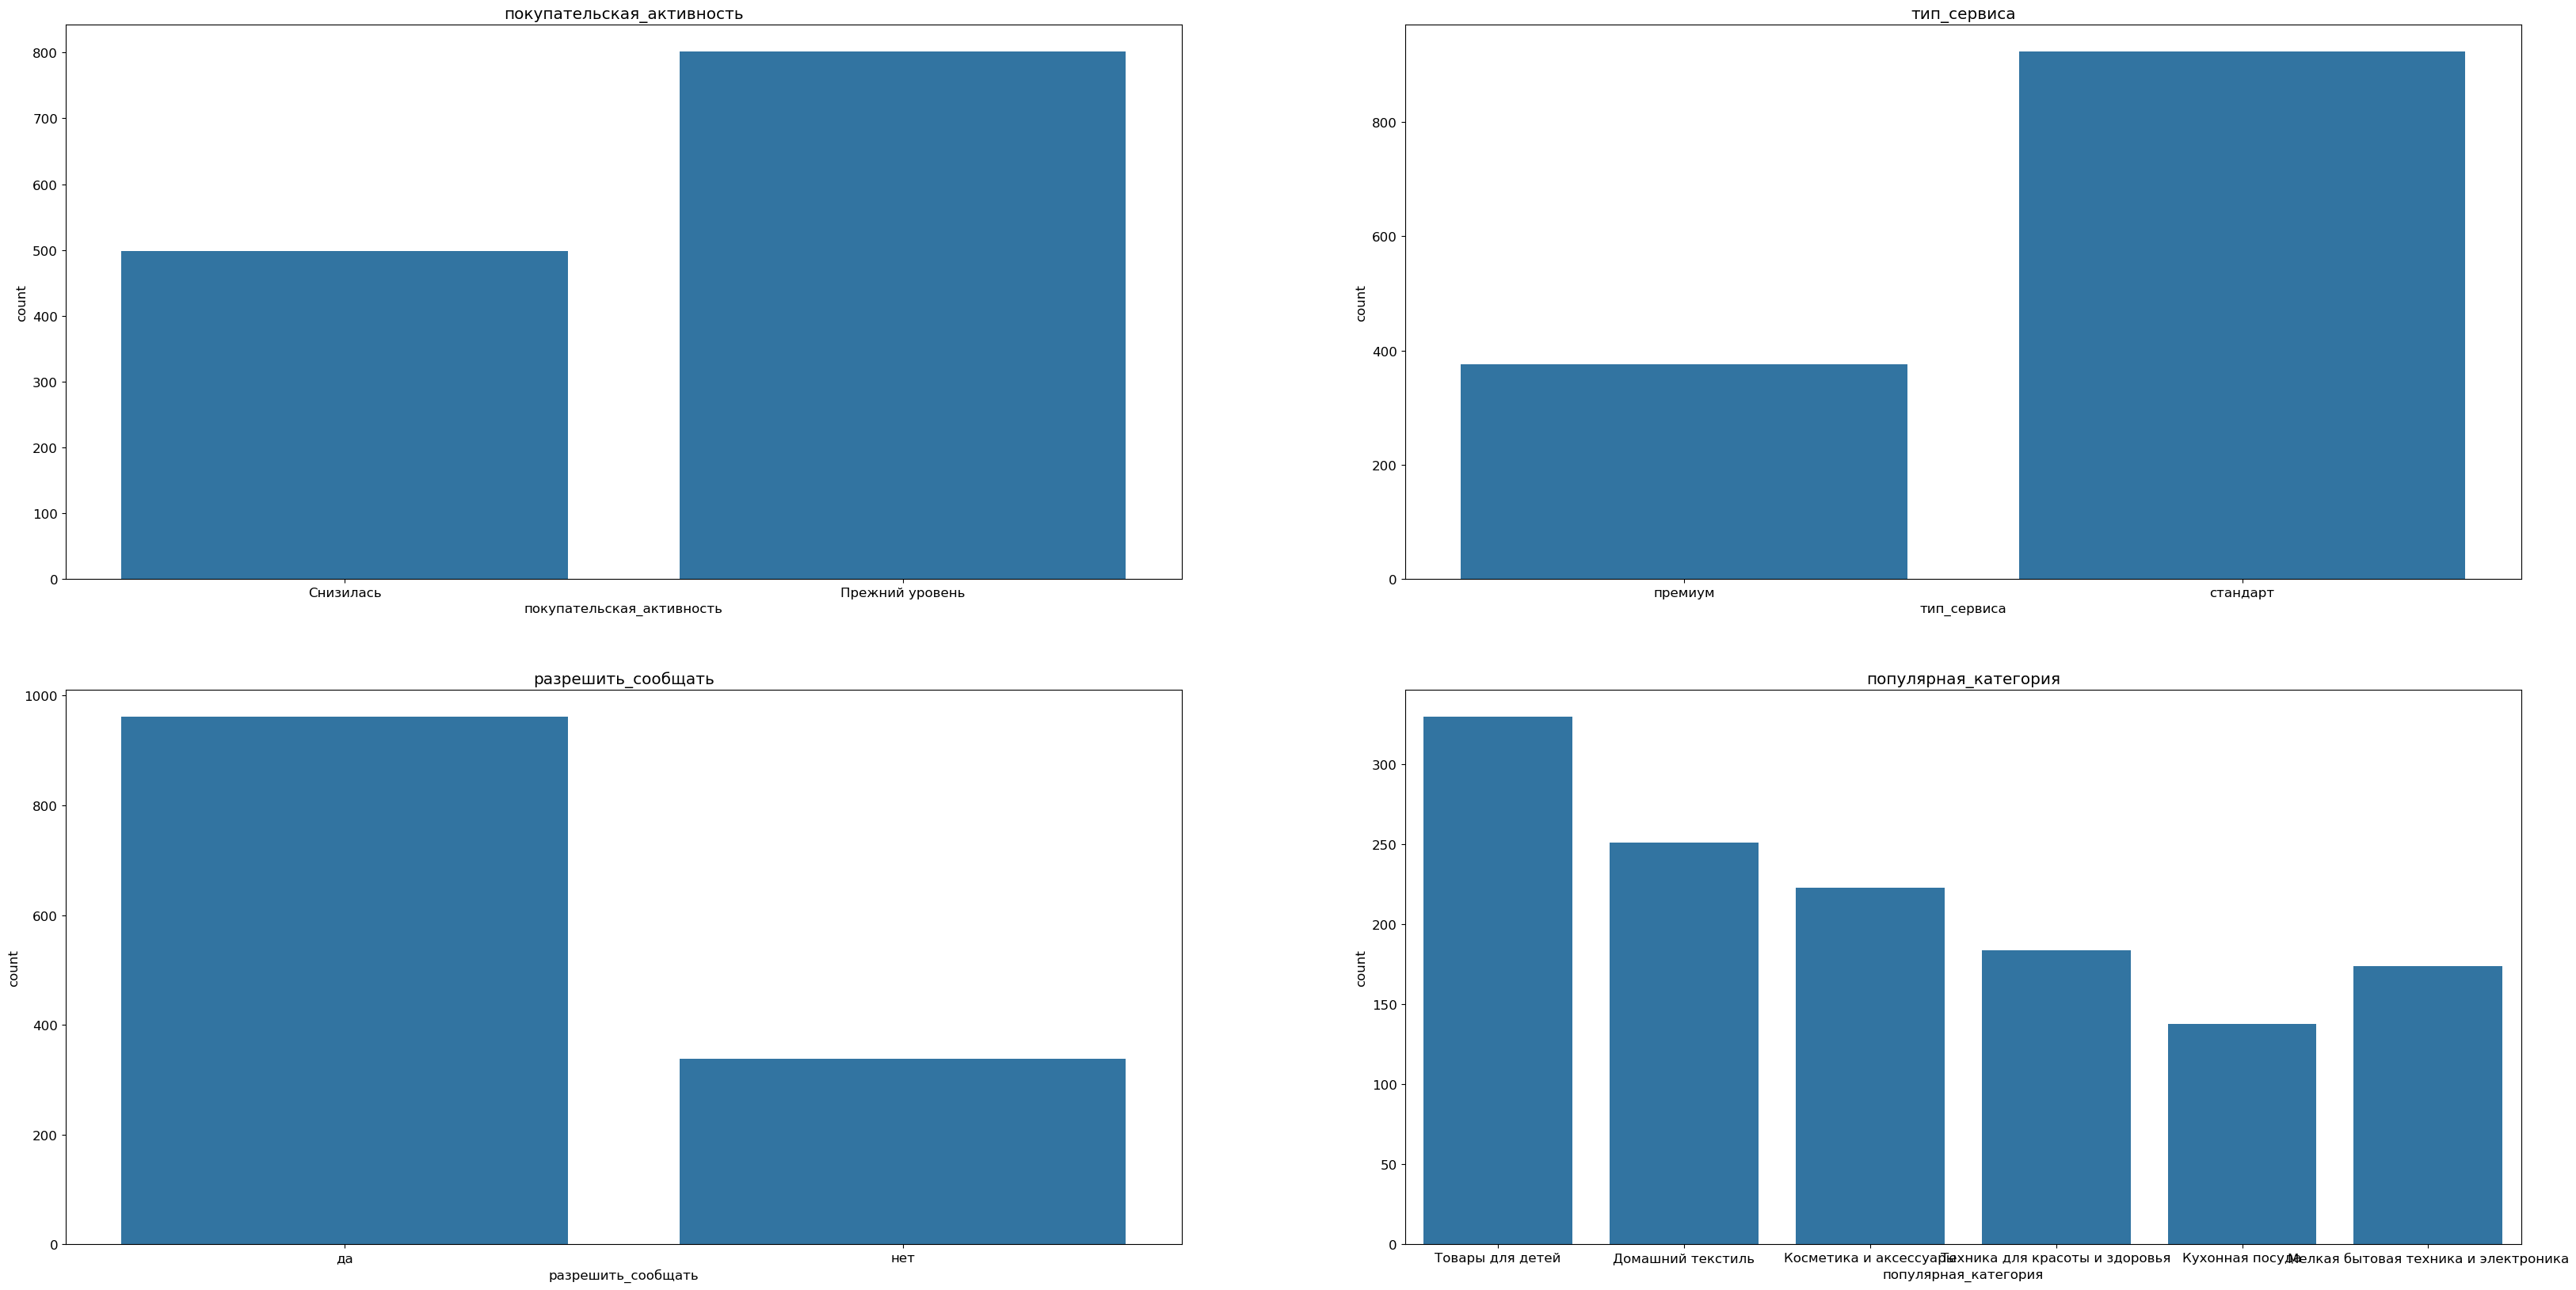

In [25]:
# делаю срез только с категориальными признаками
client_info_cat = client_info[['покупательская_активность', 'тип_сервиса', 'разрешить_сообщать', 'популярная_категория']]

plt.rcParams.update({'font.size': 12})
# создаю subplots
fig, axs = plt.subplots(2, 2, figsize=(40, 20))

axs = axs.flatten()

for i, cat in enumerate(client_info_cat):
    sns.countplot(x=client_info_cat[cat], ax=axs[i])
    axs[i].set_title(cat)
    

В распределении признаков наблюдается небольшой дисбаланс, при обучении нужно будет стратифицировать данные.

### Распределение количественных признаков


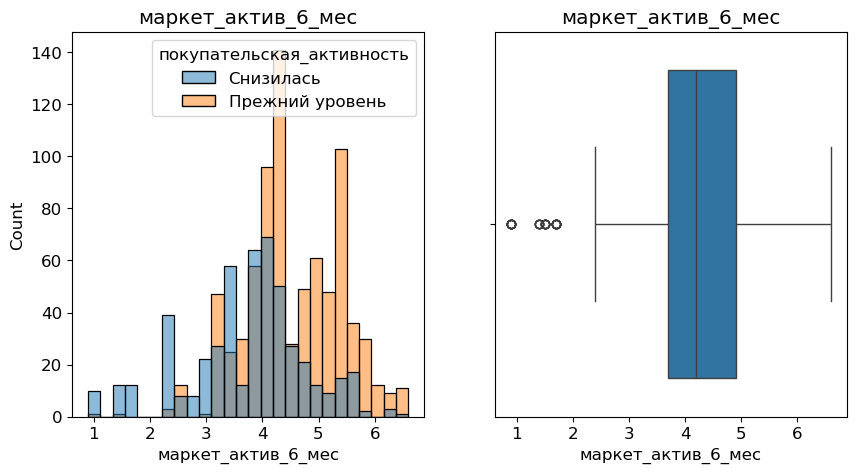

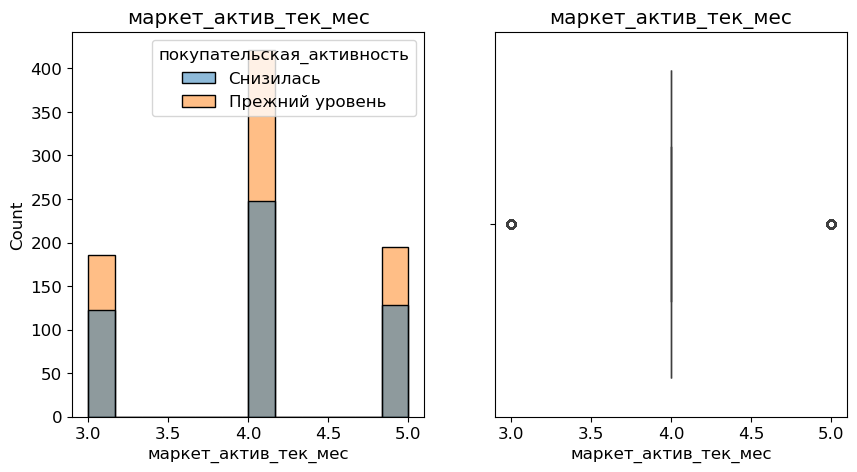

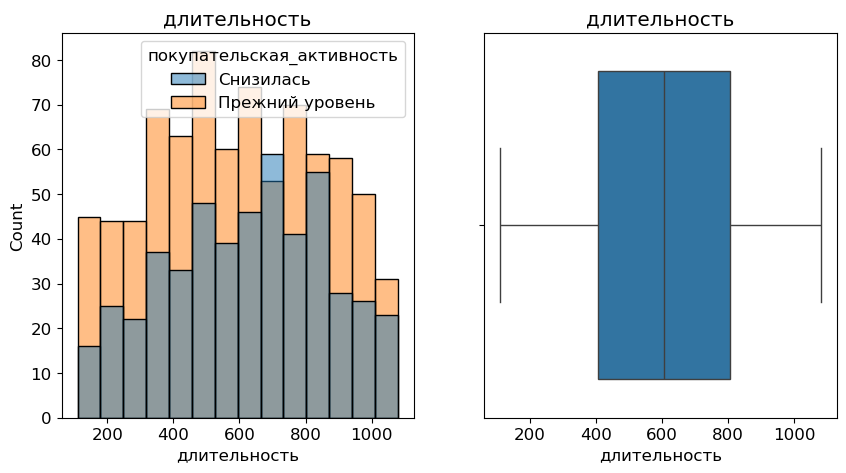

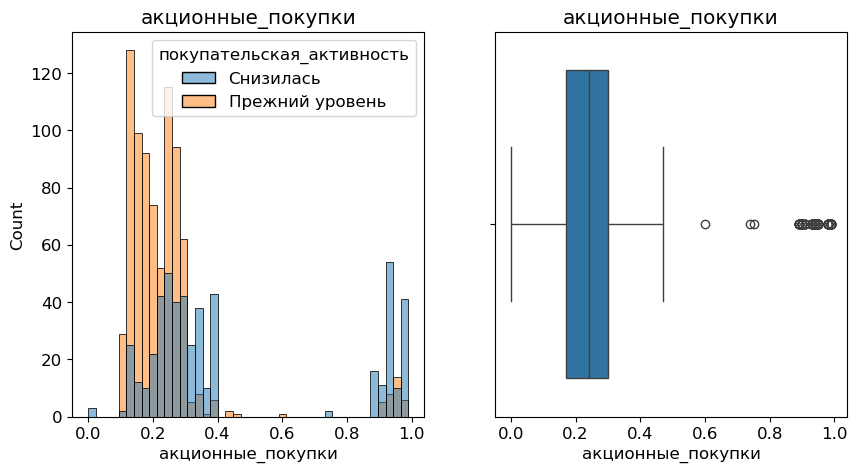

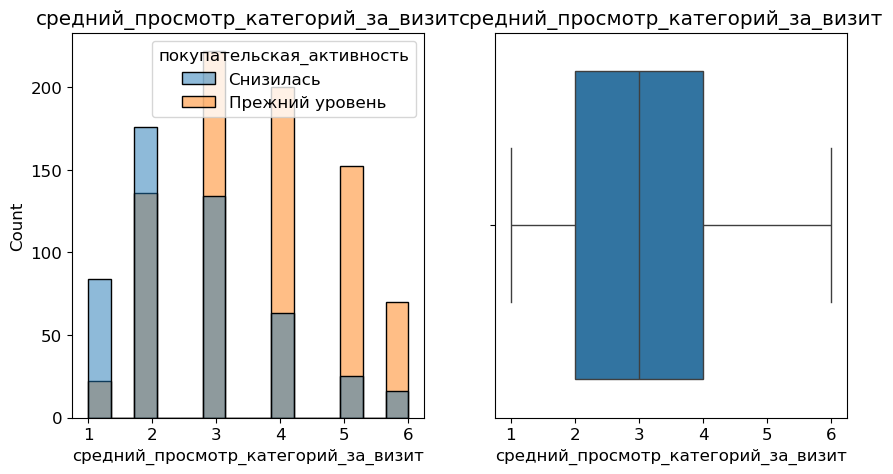

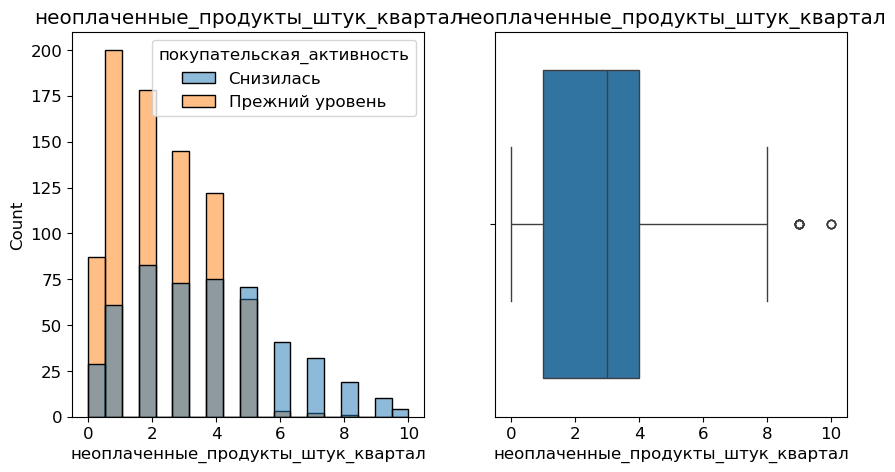

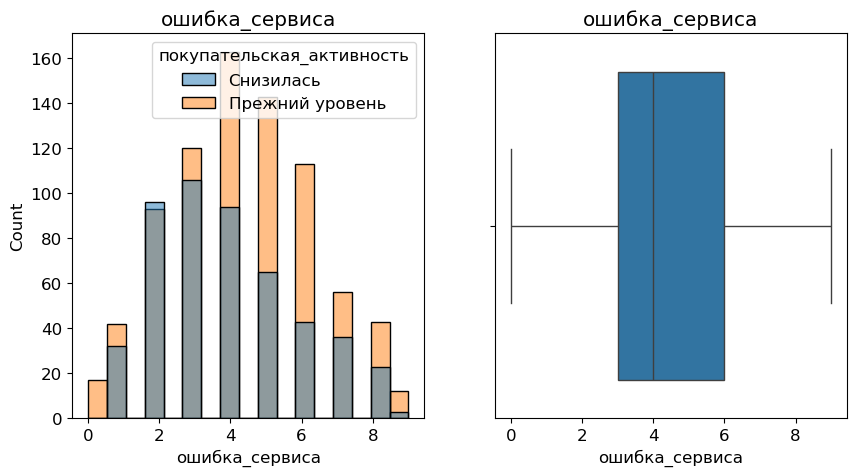

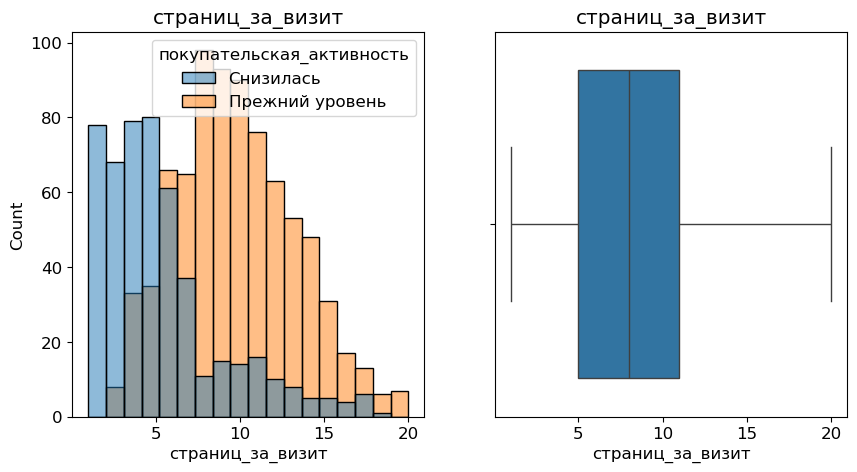

In [26]:
client_info_num = client_info[['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит']]

for num in client_info_num:
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs = axs.flatten()
    # построение гистограммы
    sns.histplot(data=client_info, x=num, hue=client_info['покупательская_активность'], ax=axs[0])
    axs[0].set_title(num)
    sns.boxplot(data=client_info, x=num, ax=axs[1]) # ящик с усами
    axs[1].set_title(num)
    
    
    plt.show()

В датафрейме, на котором будут обучаться модели, количественные признаки разных размеров. Их нужно будет привести к одному масштабу. Не все признаки распределены нормально + некоторые признаки больше похожи на категориальные.

Можно сделать предварительные выводы о том, по каким признакам можно предположить, что покупательская активность снизится: 
- Показатель маркетинговой активности за 6 месяцев меньше 4.
- Клиент совершал много акционных покупок: показатель больше 0.3.
- Клиент просматривает мало категорий (меньше 3) и страниц (меньше 7), а также оставляет много неоплаченных товаров в корзине (больше 4).


In [27]:
# посмотрю на распределение выручки по периодам
revenue_per_month = client_revenue_per_month.groupby('период')['выручка'].sum().sort_values()
revenue_per_month

период
предпредыдущий_месяц    6272769.0
предыдущий_месяц        6417996.5
текущий_месяц           6909449.0
Name: выручка, dtype: float32

<Axes: xlabel='период'>

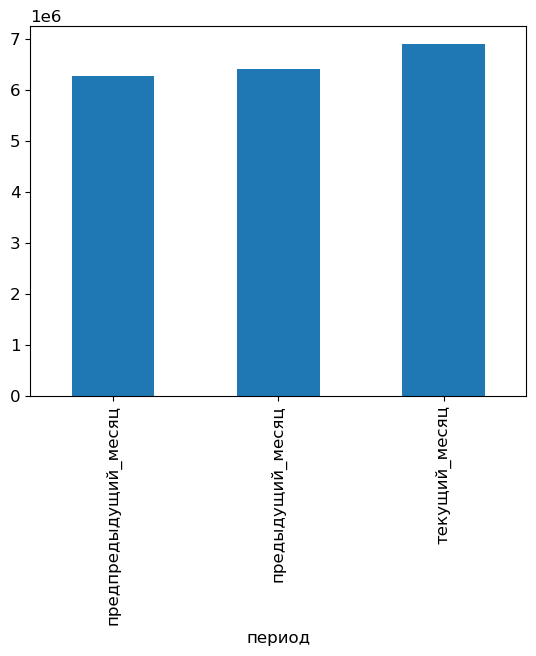

In [28]:
revenue_per_month.plot(kind='bar')

Выручка с каждого пользователя за три месяца постепенно выросла. В текущем месяце выручка больше, чем в предыдущем месяце. Значит, снижение активности пока не отразилось на доходах магазина, но может в будущем.

In [29]:
# посмотрю на распределение времени по периодам
time_per_month = client_time.groupby('период')['минут'].sum().sort_values(ascending=False)
time_per_month

период
предыдущий_месяц    17508
текущий_месяц       17166
Name: минут, dtype: int64

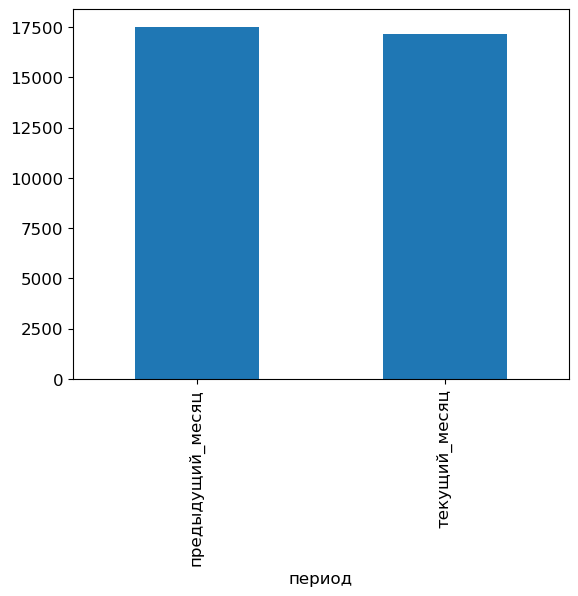

In [30]:
time_per_month.plot(kind='bar')
plt.show()

Снизилось общее время, которое покупатели проводят на сайте в течение периода.

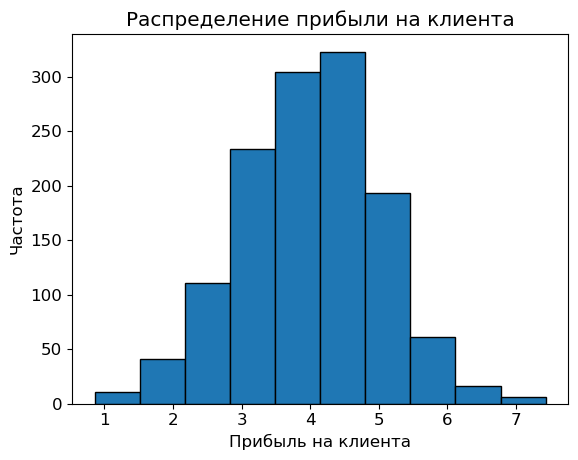

In [31]:
# посмотрю на общее распределение выручки по клиентам
plt.hist(revenue_sum['прибыль'], bins=10, edgecolor='black')
plt.xlabel('Прибыль на клиента')
plt.ylabel('Частота')
plt.title('Распределение прибыли на клиента')
plt.show()

- В данных разные диапазоны значений. Перед тем как обучать модуль на признаках, эти признаки надо с помощью масштабирования привести к одному диапазону.
- В данных много переменных с целыми значениями, можно попробовать сделать их категориальными значениями. 
- Не все признаки распределены нормально, для изучения корреляции стоит использовать коэффициент Спирмана.

### Клиенты с покупательской активностью не менее трёх месяцев

In [32]:
# отберу тех клиентов, у которых хотя бы в одном месяце выручка была равна 0
active_clients_3month = client_revenue_per_month.query('выручка == 0')
active_clients_3month


,id,период,выручка
0,215348,предпредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,предпредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,предпредыдущий_месяц,0.0


In [33]:
# выведу уникальных клиентов
active_clients_3month['id'].unique()

array([215348, 215357, 215359])

In [34]:
len(client_revenue_per_month)

3900

In [35]:
# уберу трёх клиентов из датасета

client_revenue_per_month = client_revenue_per_month[~client_revenue_per_month['id'].isin([215348, 215357, 215359])]
len(client_revenue_per_month)

3891

В данных есть три пользователя, которые были хотя бы в одном месяце неактивны. Убрала их из датасета, поскольку нас интересуют только те клиенты, которые были активны в каждый месяц.

## Объединение таблиц

In [36]:
# использую функцию pivot_table для преобразования значений столбца 'период' в новые столбцы
client_revenue_per_month = client_revenue_per_month.pivot_table(index='id', columns='период', values='выручка', aggfunc='first')

# сбрасываю индекс, чтобы 'id' стал обычным столбцом
client_revenue_per_month = client_revenue_per_month.reset_index()

columns_to_modify = ['предпредыдущий_месяц', 'предыдущий_месяц', 'текущий_месяц']

# чуть переименую столбцы

for col in columns_to_modify:
    if col in client_revenue_per_month.columns:
        client_revenue_per_month.rename(columns={col: 'выручка_' + col}, inplace=True)

client_revenue_per_month



период,id,выручка_предпредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц
0,215349,4472.0,5216.0,4971.600098
1,215350,4826.0,5457.5,5058.399902
2,215351,4793.0,6158.0,6610.399902
3,215352,4594.0,5807.5,5872.500000
4,215353,5124.0,4738.5,5388.500000
...,...,...,...,...
1292,216643,4704.0,3664.0,4741.700195
1293,216644,5299.0,4729.0,5353.000000
1294,216645,5334.0,5160.0,5139.200195
1295,216646,4725.0,4923.0,5224.600098


In [37]:
# использую функцию pivot_table для преобразования значений столбца 'период' в новые столбцы
client_time = client_time.pivot_table(index='id', columns='период', values='минут', aggfunc='first')
# сбрасываю индекс, чтобы 'id' стал обычным столбцом
client_time = client_time.reset_index()

columns_to_modify_2 = ['предыдущий_месяц', 'текущий_месяц']

for col in columns_to_modify_2:
    if col in client_time.columns:
        client_time.rename(columns={col: 'минуты_' + col}, inplace=True)

client_time

период,id,минуты_предыдущий_месяц,минуты_текущий_месяц
0,215348,13,14
1,215349,12,10
2,215350,8,13
3,215351,11,13
4,215352,8,11
...,...,...,...
1295,216643,14,7
1296,216644,12,11
1297,216645,12,18
1298,216646,18,7


In [38]:
# объединяю все таблицы
info = client_info.merge(client_time, on='id')
info

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минуты_предыдущий_месяц,минуты_текущий_месяц
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,13,14
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,12,10
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,8,13
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,11,13
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,8,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,14,7
1296,216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,12,11
1297,216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,12,18
1298,216646,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,18,7


In [39]:
data = info.merge(client_revenue_per_month, on='id')
data

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минуты_предыдущий_месяц,минуты_текущий_месяц,выручка_предпредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,12,10,4472.0,5216.0,4971.600098
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,8,13,4826.0,5457.5,5058.399902
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,11,13,4793.0,6158.0,6610.399902
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,8,11,4594.0,5807.5,5872.500000
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,10,10,5124.0,4738.5,5388.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1292,216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,14,7,4704.0,3664.0,4741.700195
1293,216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,12,11,5299.0,4729.0,5353.000000
1294,216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,12,18,5334.0,5160.0,5139.200195
1295,216646,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,18,7,4725.0,4923.0,5224.600098


## Корреляционный анализ

interval columns not set, guessing: ['id', 'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'минуты_предыдущий_месяц', 'минуты_текущий_месяц', 'выручка_предпредыдущий_месяц', 'выручка_предыдущий_месяц', 'выручка_текущий_месяц']


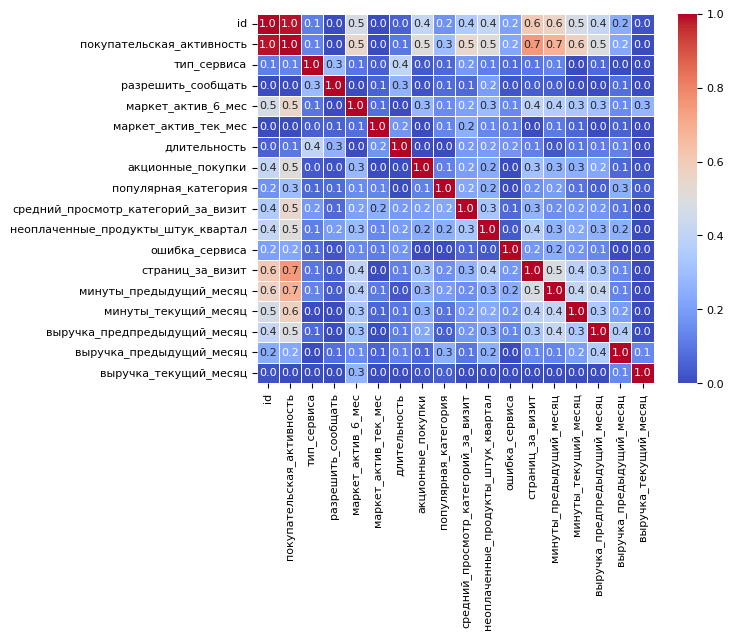

In [40]:
phik_matrix = data.phik_matrix()
plt.rcParams['font.size'] = '8'
sns.heatmap(phik_matrix, annot=True, linewidth=.5, fmt=".1f", cmap='coolwarm')
plt.show()

Мультиколлинеарности между входными признаками не наблюдается, коэффициенты корреляции между ними ниже 0.9. Но у строки с id сильная корреляция с целевым признаком. Уберу id перед обучением модели. Возможно, id пользователей присваиваются последовательно: более высокие id принадлежат более новым пользователям. Новые клиенты более активны, чем старые, поэтому и корреляция высокая.

The figure layout has changed to tight


<Figure size 1500x1500 with 0 Axes>

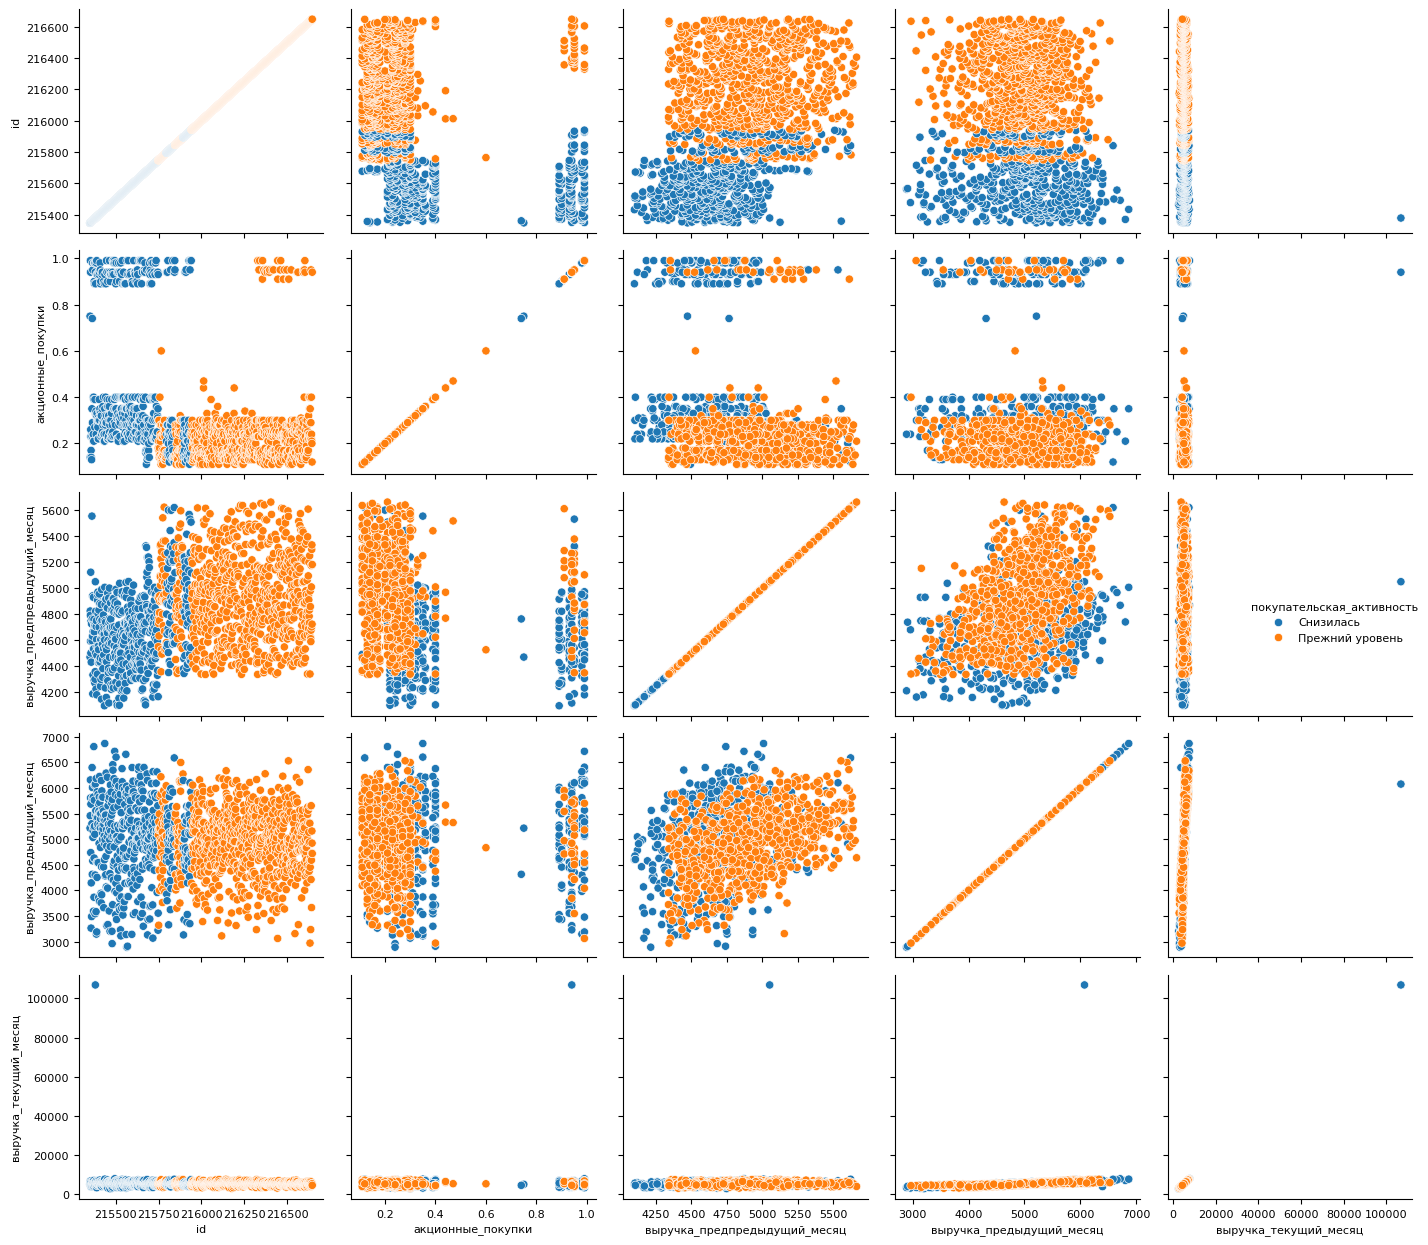

In [41]:
data_for_scatterplots = data[['покупательская_активность', 'id', 'акционные_покупки', 'выручка_предпредыдущий_месяц', 'выручка_предыдущий_месяц', 'выручка_текущий_месяц']]

plt.figure(figsize=(15, 15))
scatter_plots = sns.PairGrid(data_for_scatterplots, hue='покупательская_активность')
scatter_plots.map(sns.scatterplot)
scatter_plots.add_legend()

plt.tight_layout()
plt.show()


## Использование пайплайнов

Потребуются следующие преобразования значений перед обучением: 
- Кодировка 'тип_сервиса', 'разрешить_сообщать' с помощью OneHotEncoder. 
- Кодировка 'маркет_актив_тек_мес', 'популярная_категория', 'средний_просмотр_категорий_за_визит' c помощью OrdinalEncoder
- Кодировка 'маркет_актив_6_мес', 'акционные_покупки', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'минуты_предыдущий_месяц', 'минуты_текущий_месяц' с помощью MinMaxSxaler
- Кодировка 'длительность', 'выручка_предпредыдущий_месяц', 'выручка_предыдущий_месяц', 'выручка_текущий_месяц' с помощью StandardScaler

Для проверки качества модели выбрала метрику ROC_AUC, потому что стоит задача бинарной классификации, а также есть дисбаланс в классах.


In [42]:
# полностью удалить столбец с id из датасета нельзя, поэтому сделаю из id индексы
data.set_index('id', inplace=True)
data.head()

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минуты_предыдущий_месяц,минуты_текущий_месяц,выручка_предпредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц
id,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,12,10,4472.0,5216.0,4971.600098
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,8,13,4826.0,5457.5,5058.399902
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,11,13,4793.0,6158.0,6610.399902
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,8,11,4594.0,5807.5,5872.500000
215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,10,10,5124.0,4738.5,5388.500000


In [43]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

le = LabelEncoder()
data['покупательская_активность'] = le.fit_transform(data['покупательская_активность'])

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['покупательская_активность'], axis=1),
    data['покупательская_активность'],
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE, 
    stratify = data['покупательская_активность']
)


ohe_columns = ['тип_сервиса', 'разрешить_сообщать', 'популярная_категория']
ord_columns = ['маркет_актив_тек_мес', 'средний_просмотр_категорий_за_визит']
num_columns = ['маркет_актив_6_мес', 'акционные_покупки', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'минуты_предыдущий_месяц', 'минуты_текущий_месяц', 'длительность', 'выручка_предпредыдущий_месяц', 'выручка_предыдущий_месяц', 'выручка_текущий_месяц']

ohe_pipe = Pipeline([('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))])

ord_pipe = Pipeline([('ord', OrdinalEncoder(categories=[['3', '4', '5'], ['1', '2', '3', '4', '5', '6']]))])

data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ],
)

pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

param_distributions = [
    # словарь для модели KNeighborsClassifier() 
    {
    
        'models': [KNeighborsClassifier()],
        
        'models__n_neighbors': range(1, 20),
        #
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]
    },
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 11),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'models__C': [0.1,1,10,100],
        'models__gamma': [0.1,1,10,100],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']

    },
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    }
]
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_distributions=param_distributions,
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

best_model = randomized_search.best_estimator_

best_model


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['тип_сервиса',
                                                   'разрешить_сообщать',
                                                   'популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(categories=[['3',
                                                                                               '4',
                                                                                               '5'],
                                                                                              ['1',
                                                                                               '2',
                                                                                               '3',
                                                                                               '4',
                                                                                               '5',
                                                                                               '6']]))]),
                                                  ['маркет_актив_тек...
                                                   'средний_просмотр_категорий_за_визит']),
                                                 ('num', StandardScaler(),
                                                  ['маркет_актив_6_мес',
                                                   'акционные_покупки',
                                                   'неоплаченные_продукты_штук_квартал',
                                                   'ошибка_сервиса',
                                                   'страниц_за_визит',
                                                   'минуты_предыдущий_месяц',
                                                   'минуты_текущий_месяц',
                                                   'длительность',
                                                   'выручка_предпредыдущий_месяц',
                                                   'выручка_предыдущий_месяц',
                                                   'выручка_текущий_месяц'])])),
                ('models', KNeighborsClassifier(n_neighbors=12))])

In [44]:
result = pd.DataFrame(randomized_search.cv_results_)
print(result[['rank_test_score', 'param_models', 'mean_test_score','params']].sort_values('rank_test_score'))

pd.set_option('display.max_colwidth', 1000)

   rank_test_score                             param_models  mean_test_score  \
1                1     KNeighborsClassifier(n_neighbors=12)         0.899895   
2                2     KNeighborsClassifier(n_neighbors=12)         0.898548   
5                3   SVC(probability=True, random_state=42)         0.897803   
9                4   SVC(probability=True, random_state=42)         0.897266   
7                5   SVC(probability=True, random_state=42)         0.896995   
0                6   SVC(probability=True, random_state=42)         0.884302   
3                7   SVC(probability=True, random_state=42)         0.875196   
6                8  DecisionTreeClassifier(random_state=42)         0.846407   
4                9  DecisionTreeClassifier(random_state=42)         0.804653   
8               10   SVC(probability=True, random_state=42)         0.521550   

                                              params  
1  {'preprocessor__num': StandardScaler(), 'model...  
2  {'prep

Лучшая модель - kNN с следующими гиперпараметрами: 12 n-соседей и StandardScaler.

In [45]:
# тут вывожу предсказания по третьей модели

fourth_best_params = result.loc[result['rank_test_score'] == 4, 'params'].values[0]

fourth_best_model = clone(pipe_final)
fourth_best_model.set_params(models=fourth_best_params['models'])
fourth_best_model.set_params(preprocessor__num=fourth_best_params['preprocessor__num'])

fourth_best_model.fit(X_train, y_train)
predictions = fourth_best_model.predict(X_test)
predictions

array([1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0,

In [46]:
# вывожу вероятность значения 1, то есть значения 'Снизилась'
probabilities = fourth_best_model.predict_proba(X_test)
positive_probabilities = probabilities[:, 1]
positive_probabilities

array([0.61796593, 0.69821151, 0.04980463, 0.8690582 , 0.95069556,
       0.14011533, 0.02359995, 0.46091686, 0.94241476, 0.20123614,
       0.8949246 , 0.05446846, 0.09326285, 0.97586408, 0.27711076,
       0.08475226, 0.16818073, 0.06050641, 0.85539403, 0.94592554,
       0.07154814, 0.98120739, 0.99344801, 0.19291274, 0.88348313,
       0.13704366, 0.35139204, 0.76127676, 0.88212792, 0.2280568 ,
       0.07112055, 0.02811467, 0.01054897, 0.13496816, 0.71207842,
       0.02348681, 0.02707566, 0.53105837, 0.23645701, 0.05868877,
       0.95580219, 0.26729416, 0.4428665 , 0.01478541, 0.2371384 ,
       0.10024893, 0.70829123, 0.95302572, 0.82226991, 0.11700036,
       0.35496383, 0.97546948, 0.93005464, 0.02366973, 0.08944275,
       0.04291684, 0.78969058, 0.11574512, 0.09000067, 0.22021313,
       0.25176271, 0.05765134, 0.8977588 , 0.92813637, 0.67781661,
       0.43341609, 0.9650282 , 0.45446395, 0.05147085, 0.94224949,
       0.28087235, 0.57643529, 0.62869096, 0.01628342, 0.11129

In [47]:
roc_auc = roc_auc_score(y_test, positive_probabilities)
roc_auc

0.9256138661531055

In [48]:
# добавляю предсказания и вероятность метки 1 в общую валидационную таблицу, чуть настроила значения в колонках
data_predictions = X_test.copy()
data_predictions['активность_снизится'] = predictions
data_predictions['вероятность_снижения'] = positive_probabilities
data_predictions['активность_снизится'] = data_predictions['активность_снизится'].replace({0: 'Нет', 1: 'Да'})
data_predictions

,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минуты_предыдущий_месяц,минуты_текущий_месяц,выручка_предпредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц,активность_снизится,вероятность_снижения
id,,,,,,,,,,,,,,,,,,
216446,стандарт,да,5.3,5,433,0.91,Техника для красоты и здоровья,1,1,0,7,15,20,5160.0,4712.0,5230.700195,Да,0.617966
215469,премиум,да,4.1,3,813,0.22,Домашний текстиль,3,3,4,5,12,8,4889.0,5403.5,5228.000000,Да,0.698212
216301,премиум,да,3.9,5,410,0.20,Косметика и аксессуары,3,1,5,14,17,13,5348.0,5052.5,4926.399902,Нет,0.049805
215713,стандарт,да,4.6,5,293,0.24,Товары для детей,1,3,3,3,12,14,4872.0,4821.0,5221.399902,Да,0.869058
215500,стандарт,да,3.5,4,573,0.40,Косметика и аксессуары,2,4,1,4,11,12,4278.0,4137.0,3808.100098,Да,0.950696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215568,премиум,да,4.0,5,1073,0.40,Товары для детей,4,2,3,3,10,10,4740.0,2909.0,3933.399902,Да,0.694992
216119,премиум,да,4.1,3,208,0.13,Косметика и аксессуары,5,2,1,10,12,8,5154.0,5004.0,5004.000000,Нет,0.276347
215504,стандарт,да,3.4,5,458,0.90,Товары для детей,2,4,2,2,11,10,4543.0,3432.0,3412.500000,Да,0.985205


## Анализ важности признаков

PermutationExplainer explainer: 326it [02:59,  1.73it/s]                         


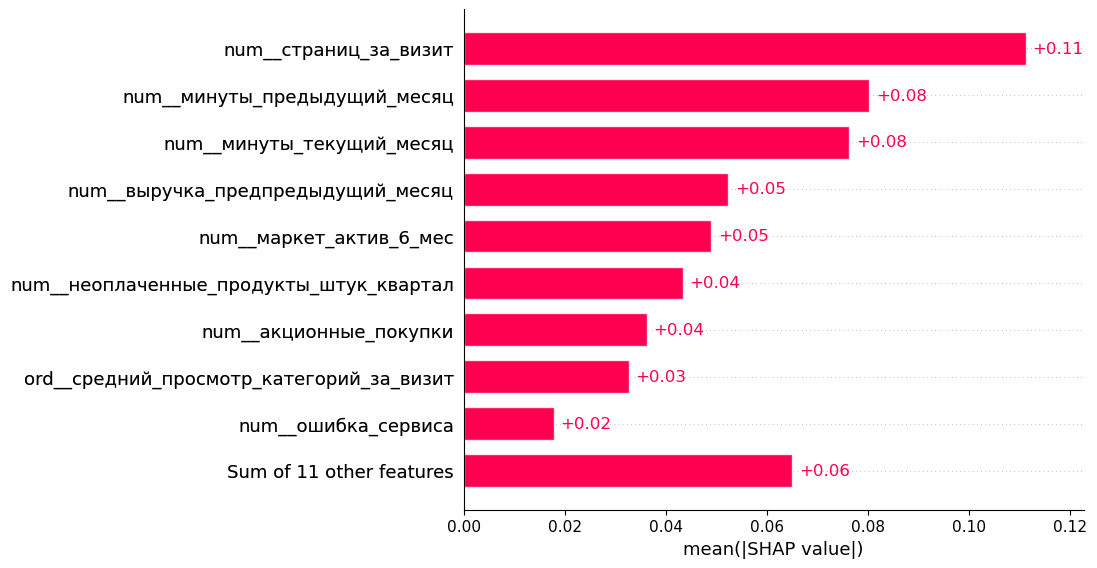

In [49]:
X_train_transformed = pipe_final.named_steps['preprocessor'].fit_transform(X_train)
X_test_transformed = pipe_final.named_steps['preprocessor'].transform(X_test)

explainer = shap.PermutationExplainer(fourth_best_model.named_steps['models'].predict_proba, X_train_transformed)
feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()
explainer.feature_names = feature_names
shap_values_ = explainer(X_test_transformed)
shap.plots.bar(shap_values_[:,:,1])

На целевой признак сильно влияют признаки от 'страниц_за_визит' до 'минуты_месяц'. Модель считает, что чем больше провёл клиент на сайте в предыдущий месяц, тем больше у него вероятность остаться активным в следующие месяцы. Предсказуемо, что клиенты, которые проводят много времени на сайте, просматривают много категорий и активны в предыдущие месяцы, продолжат быть лояльными потребителями. Чем больше у клиента купленных акционных товаров и неоплаченных продуктов в корзине, тем выше вероятность снижения его активности в следующие месяцы. 

## Сегментация покупателей

### Клиенты с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью

<div class="alert alert-info">
<font size="5"><b>Комментарий студентки</b></font>

id на индекс поменяла.

In [50]:
# возвращаю индексы в валидационную выборку
data_predictions.reset_index(inplace=True)
data_predictions

,id,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минуты_предыдущий_месяц,минуты_текущий_месяц,выручка_предпредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц,активность_снизится,вероятность_снижения
0,216446,стандарт,да,5.3,5,433,0.91,Техника для красоты и здоровья,1,1,0,7,15,20,5160.0,4712.0,5230.700195,Да,0.617966
1,215469,премиум,да,4.1,3,813,0.22,Домашний текстиль,3,3,4,5,12,8,4889.0,5403.5,5228.000000,Да,0.698212
2,216301,премиум,да,3.9,5,410,0.20,Косметика и аксессуары,3,1,5,14,17,13,5348.0,5052.5,4926.399902,Нет,0.049805
3,215713,стандарт,да,4.6,5,293,0.24,Товары для детей,1,3,3,3,12,14,4872.0,4821.0,5221.399902,Да,0.869058
4,215500,стандарт,да,3.5,4,573,0.40,Косметика и аксессуары,2,4,1,4,11,12,4278.0,4137.0,3808.100098,Да,0.950696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,215568,премиум,да,4.0,5,1073,0.40,Товары для детей,4,2,3,3,10,10,4740.0,2909.0,3933.399902,Да,0.694992
321,216119,премиум,да,4.1,3,208,0.13,Косметика и аксессуары,5,2,1,10,12,8,5154.0,5004.0,5004.000000,Нет,0.276347
322,215504,стандарт,да,3.4,5,458,0.90,Товары для детей,2,4,2,2,11,10,4543.0,3432.0,3412.500000,Да,0.985205
323,216547,стандарт,нет,4.0,3,509,0.25,Косметика и аксессуары,2,6,3,13,13,10,4847.0,4369.0,4913.700195,Нет,0.571702


In [51]:
# объединяю валидационную таблицу с данными 
new_data = data_predictions.merge(revenue_sum, on='id')
new_data

,id,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минуты_предыдущий_месяц,минуты_текущий_месяц,выручка_предпредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц,активность_снизится,вероятность_снижения,прибыль
0,216446,стандарт,да,5.3,5,433,0.91,Техника для красоты и здоровья,1,1,0,7,15,20,5160.0,4712.0,5230.700195,Да,0.617966,4.47
1,215469,премиум,да,4.1,3,813,0.22,Домашний текстиль,3,3,4,5,12,8,4889.0,5403.5,5228.000000,Да,0.698212,3.76
2,216301,премиум,да,3.9,5,410,0.20,Косметика и аксессуары,3,1,5,14,17,13,5348.0,5052.5,4926.399902,Нет,0.049805,4.34
3,215713,стандарт,да,4.6,5,293,0.24,Товары для детей,1,3,3,3,12,14,4872.0,4821.0,5221.399902,Да,0.869058,4.42
4,215500,стандарт,да,3.5,4,573,0.40,Косметика и аксессуары,2,4,1,4,11,12,4278.0,4137.0,3808.100098,Да,0.950696,4.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,215568,премиум,да,4.0,5,1073,0.40,Товары для детей,4,2,3,3,10,10,4740.0,2909.0,3933.399902,Да,0.694992,5.49
321,216119,премиум,да,4.1,3,208,0.13,Косметика и аксессуары,5,2,1,10,12,8,5154.0,5004.0,5004.000000,Нет,0.276347,4.93
322,215504,стандарт,да,3.4,5,458,0.90,Товары для детей,2,4,2,2,11,10,4543.0,3432.0,3412.500000,Да,0.985205,2.08
323,216547,стандарт,нет,4.0,3,509,0.25,Косметика и аксессуары,2,6,3,13,13,10,4847.0,4369.0,4913.700195,Нет,0.571702,3.98


The figure layout has changed to tight


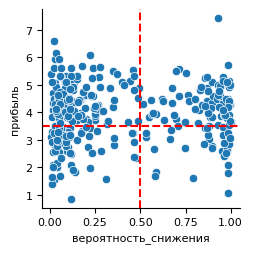

In [52]:
# смотрю на распределение вероятности снижения активности и прибыли по клиентам в целом
sns.pairplot(new_data, x_vars='вероятность_снижения', y_vars='прибыль')

x_threshold = 0.5
y_threshold = 3.5

# Draw threshold lines
plt.axvline(x=x_threshold, color='r', linestyle='--')  
plt.axhline(y=y_threshold, color='r', linestyle='--')

plt.show()
plt.show()

In [53]:
# отобрала клиентов с высокой вероятностью снижения активности и высокой прибылью

target_clients = new_data.query('вероятность_снижения > 0.5 and прибыль > 3.5')
target_clients

,id,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минуты_предыдущий_месяц,минуты_текущий_месяц,выручка_предпредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц,активность_снизится,вероятность_снижения,прибыль
0,216446,стандарт,да,5.3,5,433,0.91,Техника для красоты и здоровья,1,1,0,7,15,20,5160.0,4712.0,5230.700195,Да,0.617966,4.47
1,215469,премиум,да,4.1,3,813,0.22,Домашний текстиль,3,3,4,5,12,8,4889.0,5403.5,5228.000000,Да,0.698212,3.76
3,215713,стандарт,да,4.6,5,293,0.24,Товары для детей,1,3,3,3,12,14,4872.0,4821.0,5221.399902,Да,0.869058,4.42
4,215500,стандарт,да,3.5,4,573,0.40,Косметика и аксессуары,2,4,1,4,11,12,4278.0,4137.0,3808.100098,Да,0.950696,4.99
8,215356,стандарт,да,4.2,4,192,0.14,Косметика и аксессуары,2,2,1,3,6,7,4433.0,4146.5,4566.399902,Да,0.942415,4.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318,215669,стандарт,да,4.1,3,551,0.94,Товары для детей,2,3,3,5,8,11,4934.0,5213.0,5123.299805,Да,0.955472,4.08
319,216607,стандарт,да,3.3,4,575,0.23,Товары для детей,2,4,5,8,11,12,4463.0,4991.0,5578.600098,Да,0.833248,4.91
320,215568,премиум,да,4.0,5,1073,0.40,Товары для детей,4,2,3,3,10,10,4740.0,2909.0,3933.399902,Да,0.694992,5.49
323,216547,стандарт,нет,4.0,3,509,0.25,Косметика и аксессуары,2,6,3,13,13,10,4847.0,4369.0,4913.700195,Нет,0.571702,3.98


In [54]:
best_clients = new_data.query('вероятность_снижения <= 0.5 and прибыль > 3.5')
best_clients

,id,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минуты_предыдущий_месяц,минуты_текущий_месяц,выручка_предпредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц,активность_снизится,вероятность_снижения,прибыль
2,216301,премиум,да,3.9,5,410,0.20,Косметика и аксессуары,3,1,5,14,17,13,5348.0,5052.5,4926.399902,Нет,0.049805,4.34
6,216533,стандарт,нет,5.7,5,769,0.14,Техника для красоты и здоровья,4,1,8,10,15,20,4925.0,5868.0,5180.299805,Нет,0.023600,6.59
9,216219,премиум,да,4.1,3,784,0.23,Косметика и аксессуары,2,1,6,6,13,20,5614.0,5198.5,4968.399902,Нет,0.201236,3.77
11,215974,стандарт,да,5.1,4,458,0.20,Домашний текстиль,5,1,6,13,19,7,4899.0,4309.5,3928.600098,Нет,0.054468,3.96
14,215752,стандарт,нет,4.0,4,475,0.30,Мелкая бытовая техника и электроника,3,3,7,7,13,8,4635.0,5188.5,5798.200195,Нет,0.277111,4.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311,215783,стандарт,нет,5.5,3,159,0.25,Домашний текстиль,5,3,3,12,21,8,4671.0,4626.0,4717.000000,Нет,0.116411,5.60
312,216115,стандарт,нет,4.4,4,808,0.17,Мелкая бытовая техника и электроника,4,2,0,3,11,9,4543.0,4802.5,5157.399902,Нет,0.295888,4.06
313,216412,стандарт,да,5.5,3,847,0.11,Мелкая бытовая техника и электроника,5,1,5,4,14,16,5233.0,5227.0,5351.799805,Нет,0.032484,4.14
316,215803,стандарт,да,3.8,4,670,0.28,Товары для детей,4,4,7,9,9,22,5273.0,5601.5,6016.200195,Нет,0.112026,4.85


<Axes: xlabel='акционные_покупки', ylabel='Count'>

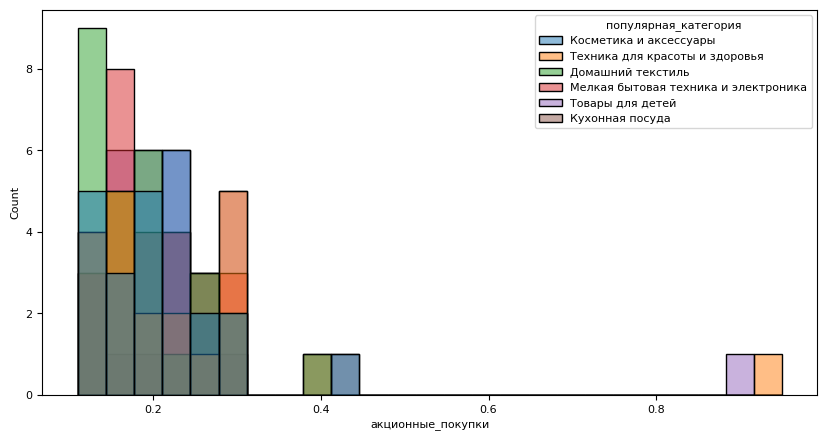

In [55]:
fig, axs = plt.subplots(figsize=(10, 5))
sns.histplot(data=best_clients, x='акционные_покупки', hue=best_clients['популярная_категория'])

<Axes: xlabel='акционные_покупки', ylabel='Count'>

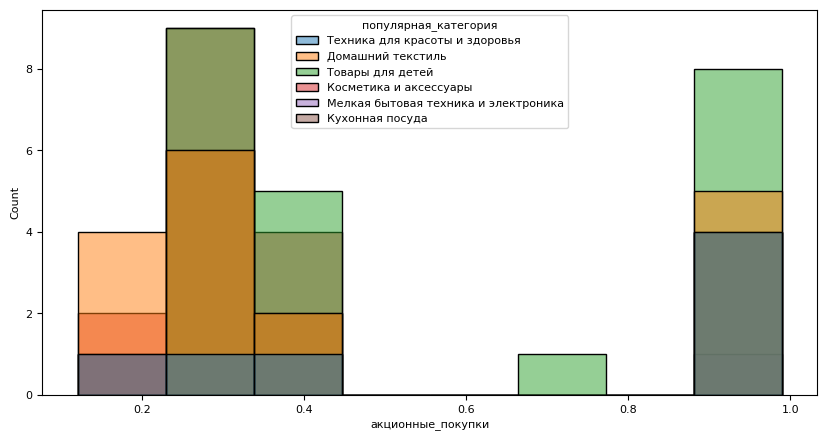

In [56]:
fig, axs = plt.subplots(figsize=(10, 5))
sns.histplot(data=target_clients, x='акционные_покупки', hue=target_clients['популярная_категория'])

Клиенты с низкой вероятностью снижения и высокой прибыльностью покупают мало акционных продуктов. Клиенты с высокой вероятностью снижения наоборот покупают больше акционки.

In [57]:
# строю таблицу по прибыли по категориям

revenue_category = target_clients.groupby('популярная_категория')['прибыль'].sum().sort_values(ascending=False)
revenue_category

популярная_категория
Товары для детей                        102.05
Косметика и аксессуары                   86.71
Домашний текстиль                        76.77
Кухонная посуда                          56.56
Техника для красоты и здоровья           30.15
Мелкая бытовая техника и электроника     16.59
Name: прибыль, dtype: float64

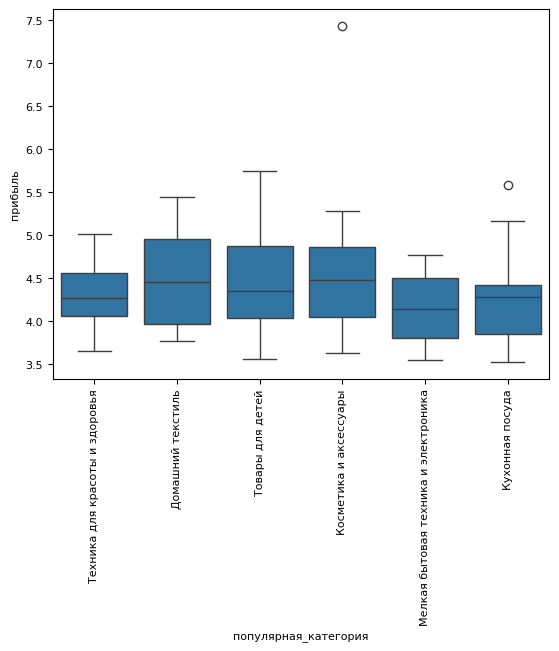

In [58]:
sns.boxplot(x='популярная_категория', y='прибыль', data=target_clients)
plt.xticks(rotation=90)
plt.show()

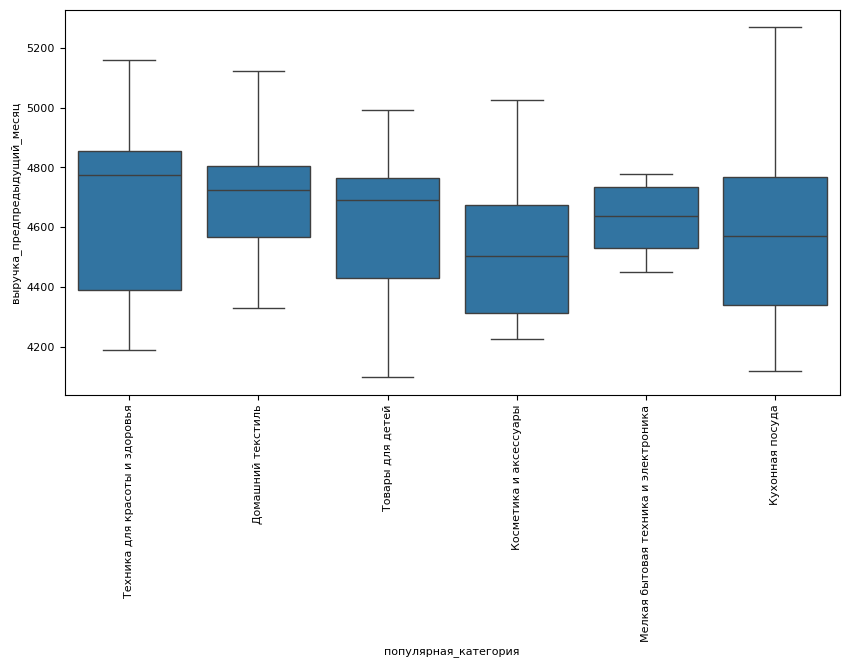

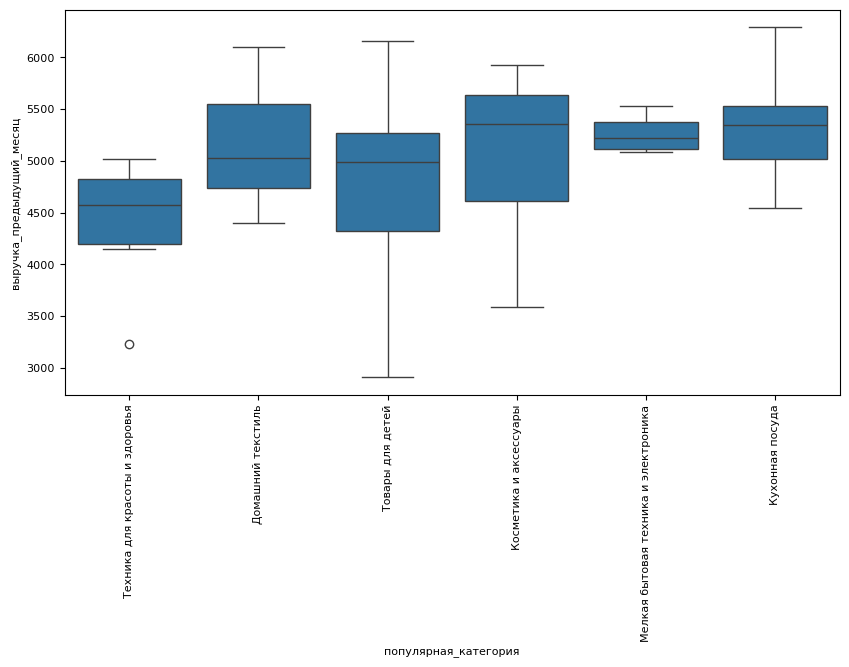

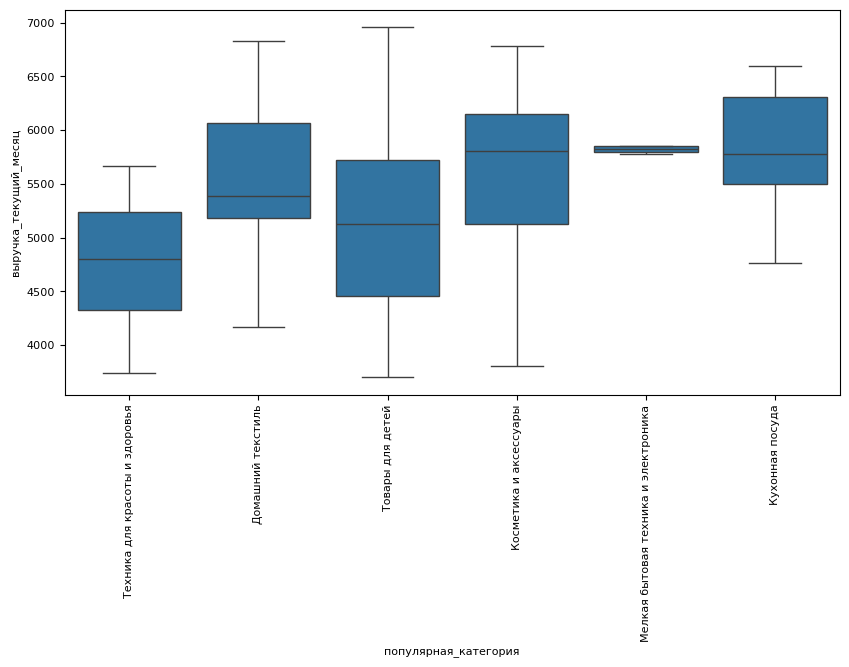

In [59]:
revenue_target_clients = target_clients[['выручка_предпредыдущий_месяц', 'выручка_предыдущий_месяц', 'выручка_текущий_месяц']]
for num in revenue_target_clients:
    fig, axs = plt.subplots(figsize=(10, 5))
    sns.boxplot(x='популярная_категория', y=num, data=target_clients)
    plt.xticks(rotation=90)
    plt.show()

Целевые клиенты покупают много товаров для детей, косметики, аксессуаров и домашнего текстиля. Покупки мелкой бытовой техники постепено снижаются. Возможно от того, что на нихдавно не было акций.

## Общий вывод

Для заказчика надо было разработать модель, которая бы предсказывала снижение активности клиентов в последующие 3 месяца. Предсказания нужно было сделать на данных о поведении покупателя на сайте, коммуникациях с покупателем и его продуктовом поведении, выручке, которую получает магазин с покупателя, и времени, которое покупатель провёл на сайте в течение периода. 

Исходные данные я предобработала:

- поправила типы данных,
- убрала неявные дубликаты,
- исправила названия некоторых категорий.

Чтобы найти лучшую модель, я написала пайплайн перебора моделей и их гиперпараметров:

1. В общем пайплайне для подготовки данных кодировала категориальные значения и масштабировала количественные. Использовала два кодировщика (`OneHotEncoder`, `OrdinalEncoder`) и скейлер (`StandardScaler`). 
2. Обучила четыре модели (`KNeighborsClassifier()`, `DecisionTreeClassifier()`, `LogisticRegression()`, `SVC()`) и перебрала для них гиперпараметры.

Лучшей оказалась модель SVC со следующими гиперпараметрами: C=0.1, gamma=10, kernel='linear', MinMaxScaler(). Модель показывает, что активность будет снижаться у клиентов с низкими показателями просмотренных категорий и страниц и времени, проведённого на сайте. Также чем больше у клиента купленных акционных товаров и неоплаченных продуктов в корзине, тем выше вероятность снижения его активности в следующие месяцы. Чтобы увеличить количество времени, проведённого на сайте, можно дополнительно проанализировать популярные категории у клиентов и присылать им предложения по товарам в этих категориях. Можно ещё прокачать категорию «Похоже на то, что вы смотрите сейчас», это может увеличить проведённое время на сайте.

Исследовала также клиентов с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью. Есть несколько особенностей таких клиентов:

- Они покупают много акционки. Клиенты с низкой вероятностью снижения активности, наоборот, покупают меньше по акциям.
- У них популярны категории “Товары для детей”, “Косметика и аксессуары”, “Домашний текстиль”. Судя по этим категориям, большинство целевых клиентов — женщины.
- В последнее время снижается количество покупок мелкой бытовой техники. Возможно из-за того, что на них давно не было акций.

**Рекомендации**: поддерживать акции на популярные категории — “Товары для детей”, “Косметика и аксессуары”, “Домашний текстиль”. Добавить акций на мелкую бытовую технику. Поскольку в основном целевые клиенты — женщины, можно ещё поработать с категорией «Техника для красоты и здоровья»: тоже добавить акций или расширить ассортимент. Можно ещё настроить рассылку по клиентам, когда появляются какие-то дешёвые новинки в этих категориях. Ещё один вариант: попросить инфлюенсеров создавать видео с интересными подборками товаров из этих категорий.